### 基尼系数

$
gini(T) = 1 - \sum p_i^2
$

基尼系数越高，系统的混乱程度越高，而建立决策树的目的就是降低系统的混乱程度。

so，一个特征对模型的整体的基尼系数下降的贡献越大，其特征重要性就越大

#### 分类后的基尼系数公式：

$
gini(T) = \frac{S_1}{S_1 + S_2} gini(T_1) + \frac{S_2}{S_1 + S_2} gini(T_2)， 其中S_1, S_2为划分后两类各自的样本量
$


例子：
![./images/ch5-1.png](./images/ch5-1.png)


#### 回归的决策树模型

划分标准使用MSE： $ MSE = \frac{1}{n} \sum\limits_{i} (y^{(i)} - \widehat{y}^{(i)})^2$，最终目的是使MSE越小

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
df = pd.read_excel('./data/员工离职预测模型.xlsx')

In [3]:
df

,工资,满意度,考核得分,工程数量,月工时,工龄,离职
0,低,3.8,0.53,2,157,3,1
1,中,8.0,0.86,5,262,6,1
2,中,1.1,0.88,7,272,4,1
3,低,7.2,0.87,5,223,5,1
4,低,3.7,0.52,2,159,3,1
...,...,...,...,...,...,...,...
14995,高,9.0,0.55,3,259,10,0
14996,高,7.4,0.95,5,266,10,0
14997,高,8.5,0.54,3,185,10,0
14998,高,3.3,0.65,3,172,10,0


In [4]:
df = df.replace({'工资': {'低': 0, '中': 1, '高': 2}})
df.head()

,工资,满意度,考核得分,工程数量,月工时,工龄,离职
0,0,3.8,0.53,2,157,3,1
1,1,8.0,0.86,5,262,6,1
2,1,1.1,0.88,7,272,4,1
3,0,7.2,0.87,5,223,5,1
4,0,3.7,0.52,2,159,3,1


In [7]:
X = df.drop(columns='离职')
y = df['离职']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [8]:
model = DecisionTreeClassifier(max_depth=3, random_state=123)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [10]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba

array([[0.98526077, 0.01473923],
       [0.98526077, 0.01473923],
       [0.28600613, 0.71399387],
       ...,
       [0.98526077, 0.01473923],
       [0.05405405, 0.94594595],
       [0.98526077, 0.01473923]])

In [11]:
a = pd.DataFrame()
a['预测值'] = list(y_pred)
a['实际值'] = list(y_test)

In [12]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_pred, y_test)
score

0.9573333333333334

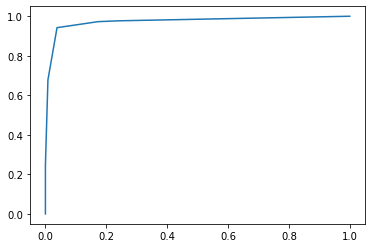

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr)
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(y_test, y_pred_proba[:, 1])
score

0.9736722483245008

决策树中各特征变量的特征重要性：

$ \frac{所有根据某特征A进行分裂的节点所产生的基尼系数下降值之和}{模型分裂到最后整个系统的基尼系数下降值} $

In [15]:
print(model.feature_importances_) 

features = X.columns
importances = model.feature_importances_

importances_df = pd.DataFrame()
importances_df['特征名称'] = features
importances_df['特征重要性'] = importances
importances_df.sort_values('特征重要性', ascending=False)

[0.         0.59810862 0.14007392 0.10638659 0.00456495 0.15086592]


,特征名称,特征重要性
1,满意度,0.598109
5,工龄,0.150866
2,考核得分,0.140074
3,工程数量,0.106387
4,月工时,0.004565
0,工资,0.000000


In [16]:
# 可视化决策树

from sklearn.tree import export_graphviz
import graphviz
import os

dot_data = export_graphviz(model, out_file=None, feature_names=X_train.columns, class_names=['不离职', '离职'], rounded=True, filled=True)
f = open('./output/dot_data.txt', 'w')
f.write(dot_data)
f.close()

import re
f_old = open('./output/dot_data.txt', 'r')
f_new = open('./output/dot_data_new.txt', 'w', encoding='utf-8')
for line in f_old:
    if 'fontname' in line:
        font_re = 'fontname=(.*?)]'
        old_font = re.findall(font_re, line)[0]
        line = line.replace(old_font, 'SimHei')
    f_new.write(line)
f_old.close()
f_new.close()

os.system('dot -Tpng ./output/dot_data_new.txt -o ./output/决策树模型.png')
os.system('dot -Tpdf ./output/dot_data_new.txt -o ./output/决策树模型.pdf')

ModuleNotFoundError: No module named 'graphviz'

### 参数调优

#####  K折交叉验证

##### GridSearch
一种穷举搜索的手段，譬如第一种参数有4种可能，第二种参数有5种可能，则所有可能可表示为4x5的网格

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [5, 7, 9, 11, 13], "criterion": ['gini', 'entropy'], 'min_samples_split': [5, 7, 9, 11, 13, 15]}
model = DecisionTreeClassifier()
grid_search = GridSearchCV(model, parameters, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=11, min_samples_split=13)

### 结论

在金融领域，逻辑回归不需要太多变量，不容易过拟合，泛化能力较强，可能一年才需要更换一次模型，但有时不够精确。
树模型不太稳定（一个变量可以反复用），容易造成过拟合，泛化能力较弱，但拟合度强，区分度强。

商业实战中，常基于逻辑回归的评分卡模型为基础，再结合决策树模型。